In [1]:
import Data_Editing_Helpers as DEH
import Classifier as CLS
import Regressor as RGS
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, r2_score
from sklearn.ensemble import StackingRegressor, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

In [2]:
## Loading ##
test = pd.read_csv("Data/test.csv")
train = pd.read_csv("Data/train.csv")

In [3]:
y_name = 'rainfall' # What you're trying to predict
x_name = 'id' # User id. Drop this column

# Set this to True if you want to run regression models, False for classification models
is_regression = True

In [4]:
# Display basic info about datasets
train_info = train.info()
test_info = test.info()

# Display first few rows
train_head = train.head()
test_head = test.head()

# Check for missing values
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()

# Summary statistics
train_description = train.describe()
test_description = test.describe()

train_info, test_info, train_head, test_head, missing_values_train, missing_values_test, train_description, test_description


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -----------

(None,
 None,
    id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
 0   0    1    1017.4     21.2         20.6     19.9      19.4      87.0   
 1   1    2    1019.5     16.2         16.9     15.8      15.4      95.0   
 2   2    3    1024.1     19.4         16.1     14.6       9.3      75.0   
 3   3    4    1013.4     18.1         17.8     16.9      16.8      95.0   
 4   4    5    1021.8     21.3         18.4     15.2       9.6      52.0   
 
    cloud  sunshine  winddirection  windspeed  rainfall  
 0   88.0       1.1           60.0       17.2         1  
 1   91.0       0.0           50.0       21.9         1  
 2   47.0       8.3           70.0       18.1         1  
 3   95.0       0.0           60.0       35.6         1  
 4   45.0       3.6           40.0       24.8         0  ,
      id  day  pressure  maxtemp  temparature  mintemp  dewpoint  humidity  \
 0  2190    1    1019.5     17.5         15.8     12.7      14.9      96.0   
 1  2191    2    1016.5

In [5]:
## Wrangling ##
#Future implementation will remove map_seasons and convert_strings_to_ascii
train, test = DEH.map_seasons(train, test)

#train = DEH.convert_strings_to_ascii(train)
#test = DEH.convert_strings_to_ascii(test)
train, test = DEH.dropUnusedColumns(train, test, y_name, x_name)
train = DEH.remove_blank_rows(train, y_name)


Deleting unsililare rows: ['id']


In [6]:
from sklearn.preprocessing import StandardScaler

# Convert winddirection into sin and cos
train['winddirection_sin'] = np.sin(np.deg2rad(train['winddirection']))
train['winddirection_cos'] = np.cos(np.deg2rad(train['winddirection']))
test['winddirection_sin'] = np.sin(np.deg2rad(test['winddirection']))
test['winddirection_cos'] = np.cos(np.deg2rad(test['winddirection']))

# Add new feature temperature_range
train['temperature_range'] = train['maxtemp'] - train['mintemp']
test['temperature_range'] = test['maxtemp'] - test['mintemp']

# Normalize numerical features
scaler = StandardScaler()
numerical_features = ['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'windspeed', 'temperature_range', 'winddirection_sin', 'winddirection_cos']

train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

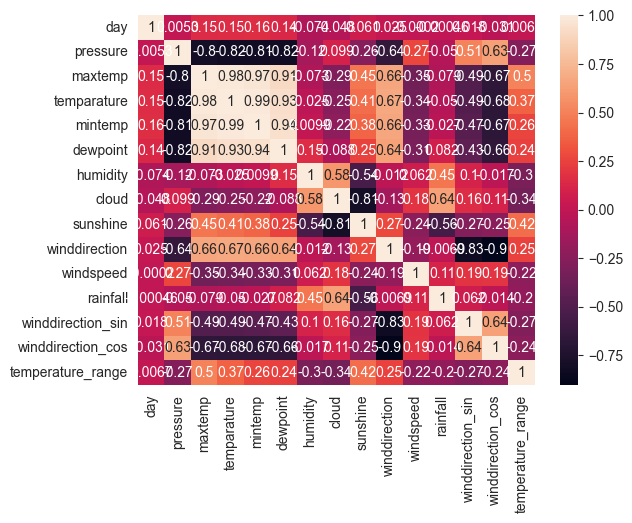

<Figure size 2000x2000 with 0 Axes>

done


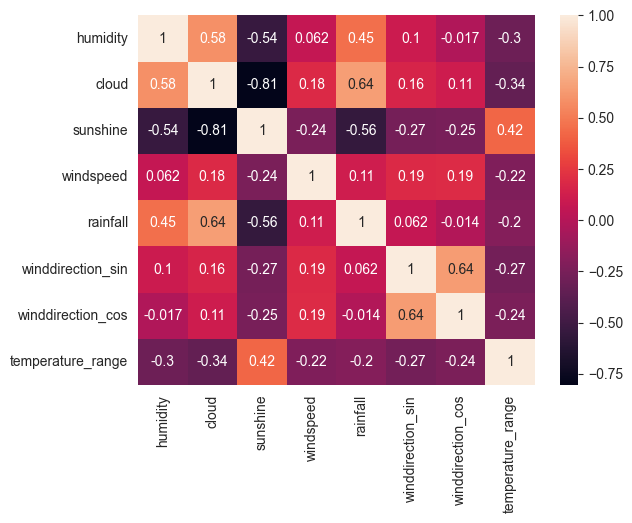

<Figure size 2000x2000 with 0 Axes>

done


In [7]:
## Visualizing ##
DEH.makeSNS(train)   # This outputs all graphs, can be annoying

test = test.drop(columns=['day', 'pressure', 'maxtemp', 'temparature', "mintemp", 'winddirection', "dewpoint"])
train = train.drop(columns=['day', 'pressure', 'maxtemp', 'temparature', "mintemp", 'winddirection', "dewpoint"])

DEH.makeSNS(train)  


In [8]:
# Using 99 as a filler for NA's. Will change to use Random Forest for filling NA's 
train, test = DEH.fill_NA(train, test, fill=99)
X_train, X_test, y_train, y_test = DEH.traintestslpit(train, y_name)

In [ ]:


def evaluate_model(model_func, X_train, y_train, X_test, y_test, model_name, results, is_regression):
    model = model_func(X_train, y_train)
    predictions = model.predict(X_test)
    if is_regression:
        score = r2_score(y_test, predictions) * 100
    else:
        score = accuracy_score(y_test, predictions) * 100
    results.append({"model": model_name, "score": score, "model_obj": model})
    print(f"{model_name} score: {score:.3f}")

## Training Models ##
results = []

if is_regression:
    evaluate_model(RGS.decisiontreeRegressor, X_train, y_train, X_test, y_test, "Decision Tree Regressor", results, is_regression)
    evaluate_model(RGS.linearRegressor, X_train, y_train, X_test, y_test, "Linear Regressor", results, is_regression)
    evaluate_model(RGS.ridgeRegressor, X_train, y_train, X_test, y_test, "Ridge Regressor", results, is_regression)
    evaluate_model(RGS.lassoRegressor, X_train, y_train, X_test, y_test, "Lasso Regressor", results, is_regression)
    evaluate_model(RGS.randomForestRegressor, X_train, y_train, X_test, y_test, "Random Forest Regressor", results, is_regression)
    evaluate_model(RGS.gradientBoostingRegressor, X_train, y_train, X_test, y_test, "Gradient Boosting Regressor", results, is_regression)
    evaluate_model(RGS.catBoostRegressor, X_train, y_train, X_test, y_test, "Cat Boost Regressor", results, is_regression)
    evaluate_model(RGS.knnRegressor, X_train, y_train, X_test, y_test, "KNN Regressor", results, is_regression)
    evaluate_model(RGS.xgBoostRegressor, X_train, y_train, X_test, y_test, "XGBoost Regressor", results, is_regression)

else:
    evaluate_model(CLS.decisiontreeClassifier, X_train, y_train, X_test, y_test, "Decision Tree Classifier", results, is_regression)
    evaluate_model(CLS.knnClassifier, X_train, y_train, X_test, y_test, "KNN Classifier", results, is_regression)
    evaluate_model(CLS.adaboostClassifier, X_train, y_train, X_test, y_test, "AdaBoost Classifier", results, is_regression)




Decision Tree Regressor Started
Best parameters Decisiontree: {'regressor__min_weight_fraction_leaf': 0.0, 'regressor__min_samples_split': 20, 'regressor__min_samples_leaf': 3, 'regressor__max_leaf_nodes': None, 'regressor__max_depth': 3}
Model saved to ./TrainedModels/decisiontreeRegressor.pkl
Decision Tree Regressor Finished
Decision Tree Regressor score: 41.244

Linear Regressor Started
Model saved to ./TrainedModels/linearRegressor.pkl
Linear Regressor Finished
Linear Regressor score: 40.107

Ridge Regressor Started
Best parameters Ridge: {'regressor__alpha': 10.0}
Model saved to ./TrainedModels/ridgeRegressor.pkl
Ridge Regressor Finished
Ridge Regressor score: 40.096

Lasso Regressor Started
Best parameters Lasso: {'regressor__alpha': 0.001}
Model saved to ./TrainedModels/lassoRegressor.pkl
Lasso Regressor Finished
Lasso Regressor score: 40.126

Random Forest Regressor Started
Best parameters RandomForest: {'regressor__n_estimators': 50, 'regressor__min_samples_split': 10, 'regre

In [17]:
# Evaluate the stacking model
for model in results:
    model['cv_score'] = cross_val_score(model['model_obj'], X_train, y_train, cv=5, scoring='r2').mean()

top_3_models = sorted(results, key=lambda x: x['cv_score'], reverse=True)[:3]

# Create the stacking model
if is_regression:
    estimators = [(model['model'], model['model_obj']) for model in top_3_models]
    stacking_model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=1.0))
else:
    estimators = [(model['model'], model['model_obj']) for model in top_3_models]
    stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

# Fit the stacking model
stacking_model.fit(X_train, y_train)

# Evaluate the stacking model
stacking_predictions = stacking_model.predict(X_test)
if is_regression:
    stacking_score = r2_score(y_test, stacking_predictions) * 100
else:
    stacking_score = accuracy_score(y_test, stacking_predictions) * 100

print(f"Stacking Model score: {stacking_score:.3f}")

Stacking Model score: 48.163


In [18]:
# Print the top 3 models
print("Top 3 Models:")
for model in top_3_models:
    print(f"{model['model']}: {model['score']:.3f}")

Top 3 Models:
Random Forest Regressor: 50.037
XGBoost Regressor: 48.146
Lasso Regressor: 40.126


In [ ]:
# Save the predictions to a CSV file for submission
test = pd.read_csv('Data/test.csv')
submission = pd.DataFrame({
    'Id': test[x_name]
    'Prediction': stacking_predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
